In [1]:
import u_net
import os
import cv2
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tqdm import tqdm
print(tf.config.list_physical_devices('GPU'))

X_TRAIN_PATH = '../datasets/Dataset_UHCSDB/Patched/images_patched/'
Y_TRAIN_PATH = '../datasets/Dataset_UHCSDB/Patched/labels_png_patched/'
METADATA_PATH = '../datasets/Dataset_UHCSDB/UHCSDB_Metadata_Segmentierung.xlsx'

n_classes = 4

def load_and_augment_data(image_path, mask_path):
    images = []
    masks = []
    angles = [90, 180, 270]

    for file in os.listdir(image_path):
        if file.endswith('.png'):
            img = cv2.imread(os.path.join(image_path, file), cv2.IMREAD_GRAYSCALE)

            # Load metadata from the Excel file
            metadata = pd.read_excel(METADATA_PATH)
            
            # Extract the corresponding metadata row for the current image
            meta_row = metadata[metadata['patch_id'] == file]
            
            # Ensure metadata exists for the current image
            if not meta_row.empty:
                scale = meta_row['scale_um_per_px'].values[0] # float between 0.0 and 1.0
                microconstituent = meta_row['primary_microconstituent'].values[0] # 'spheroidite' or 'spheroidite+widmanstatten'
                # convert microconstituent to a numerical label 0 or 1
                if microconstituent == 'spheroidite':
                    microconstituent = 0
                else:
                    microconstituent = 1
                anneal_time_min = meta_row['anneal_time_min'].values[0] # int, could be '-' though
                if anneal_time_min == '-':
                    anneal_time_min = 0
                    anneal_temp_c = 0
                    cooling_type = 0
                else:
                    anneal_temp_c = meta_row['anneal_temperature_C'].values[0] # int
                    cooling_type = meta_row['cooling'].values[0] # 'AR' or 'Q'
                    # convert cooling type to a numerical label 0 or 1
                    if cooling_type == 'AR':
                        cooling_type = 0
                    else:
                        cooling_type = 1
                
                # Add metadata to image in the form of 5 new channels
                meta_channels = np.zeros((img.shape[0], img.shape[1], 5), dtype=np.float32)
                meta_channels[..., 0] = scale
                meta_channels[..., 1] = microconstituent
                meta_channels[..., 2] = anneal_time_min
                meta_channels[..., 3] = anneal_temp_c
                meta_channels[..., 4] = cooling_type

                img = np.concatenate([img[..., np.newaxis], meta_channels], axis=-1)

            images.append(img)

    for file in os.listdir(mask_path):
        if file.endswith('.png'):
            mask = cv2.imread(os.path.join(mask_path, file), cv2.IMREAD_GRAYSCALE)
            masks.append(mask)

    augmented_images = []
    augmented_masks = []

    for img, mask in tqdm(zip(images, masks), total=len(images), desc="Augmenting data"):
        augmented_images.append(img)
        augmented_masks.append(mask)
        #for angle in angles:
        #    rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE if angle == 90 else cv2.ROTATE_180 if angle == 180 else cv2.ROTATE_90_COUNTERCLOCKWISE)
        #    rotated_mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE if angle == 90 else cv2.ROTATE_180 if angle == 180 else cv2.ROTATE_90_COUNTERCLOCKWISE)
        #    augmented_images.append(rotated_img)
        #    augmented_masks.append(rotated_mask)

    return augmented_images, augmented_masks

train_images, train_masks = load_and_augment_data(X_TRAIN_PATH, Y_TRAIN_PATH)

print("Number of training images:", len(train_images))
print("Shape of a single training image:", train_images[0].shape)
print("Number of training masks:", len(train_masks))
print("Shape of a single training mask:", train_masks[0].shape)

2025-06-01 16:14:48.821089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748787288.830954   17286 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748787288.833954   17286 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748787288.841631   17286 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748787288.841640   17286 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748787288.841641   17286 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Augmenting data: 100%|██████████| 96/96 [00:00<00:00, 1187767.50it/s]

Number of training images: 96
Shape of a single training image: (322, 322, 6)
Number of training masks: 96
Shape of a single training mask: (322, 322)


In [2]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Turn the lists into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print("Class values in Y_train:")
unique_classes = np.unique(Y_train)
print(unique_classes)   # [0 1 2 3]

# print shape of X_train and Y_train
print("Shape of X_train:", X_train.shape)  # (number_of_images, height, width, channels)
print("Shape of Y_train:", Y_train.shape)  # (number_of_images, height, width, channels)
# both are (76, 322, 322)

# Convert Y_train to categorical
from keras.utils import to_categorical
train_masks_cat = to_categorical(Y_train, num_classes=n_classes)
Y_train_cat = train_masks_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))

test_masks_cat = to_categorical(Y_test, num_classes=n_classes)
Y_test_cat = test_masks_cat.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], n_classes))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train.flatten()
)
# Normalize class weights
class_weights = class_weights / class_weights.sum()
print("Class weights:", class_weights)  # [0.338 1.862 2.514 9.083]

Class values in Y_train:
[0 1 2 3]
Shape of X_train: (76, 322, 322, 6)
Shape of Y_train: (76, 322, 322)
Class weights: [0.02452412 0.13497139 0.18221428 0.65829021]


In [3]:
model = u_net.unet_model_same_padding(in_channels=6)
#model.compile(optimizer='adam', loss=[u_net.make_weighted_jaccard_loss(class_weights=class_weights)], metrics=[u_net.jaccard_coeff_multiclass])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[u_net.jaccard_coeff_multiclass])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_focal_crossentropy', metrics=[u_net.jaccard_coeff_multiclass])

os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss
metrics = [
    sm.metrics.IOUScore(threshold=0.5, class_weights=class_weights),
    sm.metrics.FScore(threshold=0.5, class_weights=class_weights)
]

model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = model.fit(
    X_train,
    Y_train_cat,
    batch_size=4,
    verbose=1,
    epochs=50,
    validation_data=(X_test, Y_test_cat),
    shuffle=True,
    callbacks=[
        #early_stopping,
        model_checkpoint
        ],
)

I0000 00:00:1748787306.261614   17286 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6


Segmentation Models: using `tf.keras` framework.
Epoch 1/50


I0000 00:00:1748787310.963151   17399 service.cc:152] XLA service 0x7f4228025650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748787310.963236   17399 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-06-01 16:15:11.076555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748787311.659854   17399 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748787335.811823   17399 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 623ms/step - f1-score: 0.0073 - iou_score: 0.0055 - loss: 1.2449 - val_f1-score: 0.0064 - val_iou_score: 0.0051 - val_loss: 1.2474
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - f1-score: 0.0064 - iou_score: 0.0051 - loss: 1.2430 - val_f1-score: 0.0068 - val_iou_score: 0.0053 - val_loss: 1.2465
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - f1-score: 0.0074 - iou_score: 0.0056 - loss: 1.2392 - val_f1-score: 0.0081 - val_iou_score: 0.0059 - val_loss: 1.2463
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - f1-score: 0.0091 - iou_score: 0.0066 - loss: 1.2343 - val_f1-score: 0.0079 - val_iou_score: 0.0059 - val_loss: 1.2441
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - f1-score: 0.0077 - iou_score: 0.0059 - loss: 1.2389 - val_f1-score: 0.0123 - val_iou_score: 0.0082 - val_loss: 1.2403
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - f1-score: 0.0071 - iou_score: 0.0055 - loss: 1.2584 - val_f1-score: 0.0084 - val_iou_score: 0.00

In [ ]:
model = tf.keras.models.load_model('best models/best_small_cross_entropy.keras')

In [ ]:
model = tf.keras.models.load_model('best models/best_large_focal_loss.keras', custom_objects={
    'jaccard_coeff_multiclass': u_net.jaccard_coeff_multiclass
})

In [5]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

#model = tf.keras.models.load_model('best models/best_large_mixed_loss.keras', compile=False)
model = tf.keras.models.load_model('best_model.keras', compile=False)

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss
metrics = [
    sm.metrics.IOUScore(threshold=0.5, class_weights=class_weights),
    sm.metrics.FScore(threshold=0.5, class_weights=class_weights)
]

model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

In [6]:
# Evaluate the model
results = model.evaluate(X_test, Y_test_cat, batch_size=4, verbose=1)

# Print the results
print(f"Test Loss: {results[0]}")  # Loss is the first value
for i, metric in enumerate(metrics, start=1):  # Metrics start from the second value
	print(f"Test {metric.name}: {results[i]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - f1-score: 0.0122 - iou_score: 0.0087 - loss: 1.2571
Test Loss: 1.2299118041992188
Test iou_score: 0.016345595940947533
Test f1-score: 0.02428911067545414


In [7]:
#IOU
y_pred = model.predict(X_test, batch_size=4)
y_pred_argmax=np.argmax(y_pred, axis=3)

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(Y_test, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = IOU_keras.total_cm.numpy()
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Mean IoU = 0.2228291
[[1506291   13982    4253    3589]
 [ 294459    8020     959     384]
 [ 191998      56    5531    1168]
 [  37099       8     834    5049]]
IoU for class1 is:  0.7341776532397251
IoU for class2 is:  0.025230598864937646
IoU for class3 is:  0.027006967807459998
IoU for class4 is:  0.10490120712222892


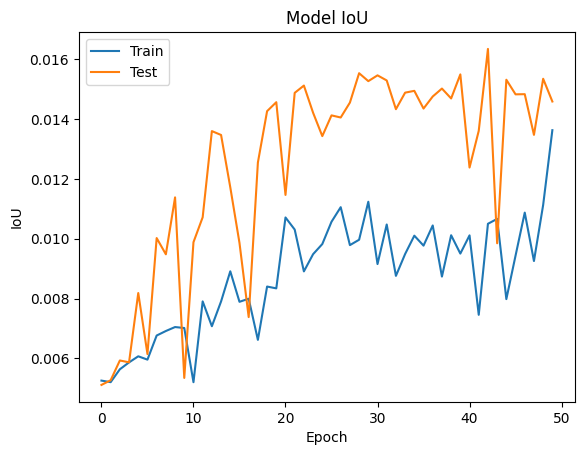

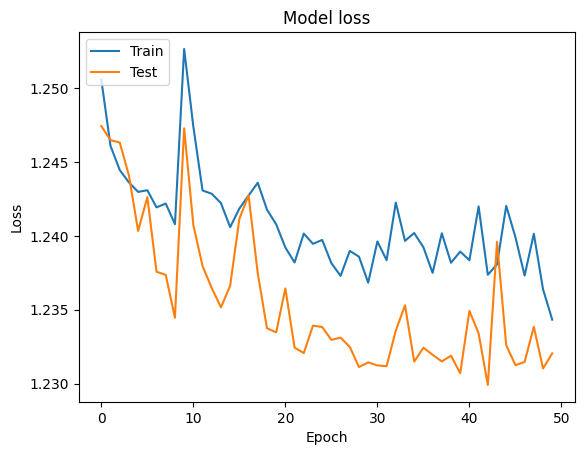

In [4]:

# plot the training history
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


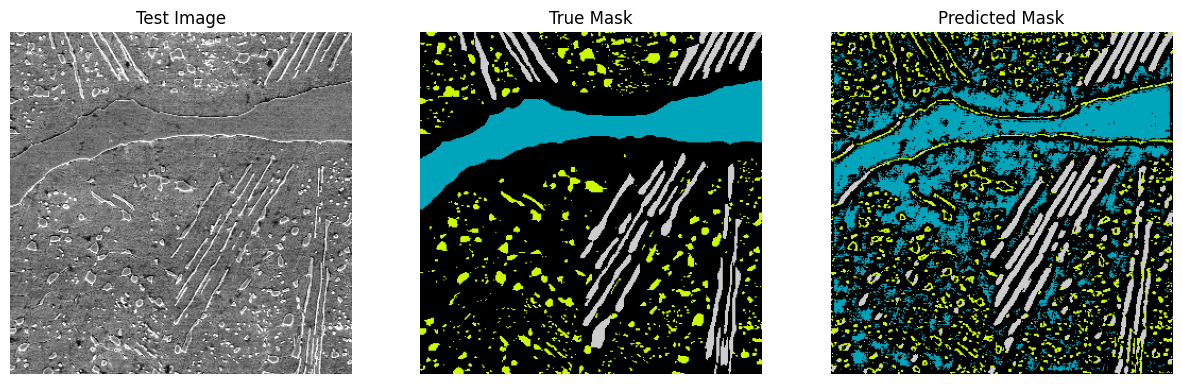

In [56]:
#random.seed(43)
# Pick a random test image
import matplotlib.pyplot as plt
idx = random.randint(0, X_test.shape[0] - 1)
test_img = X_test[idx]
true_mask = Y_test[idx]

# Predict the mask
pred_mask = model.predict(np.expand_dims(test_img, axis=0))
pred_mask = np.argmax(pred_mask, axis=-1)[0]

# Print a 5x5 slice of the test image and predicted mask
#print("5x5 slice of test image:")
#for i in range(test_img.shape[-1]):  # Iterate over all channels
#    print(f"5x5 slice of channel {i}:")
#    print(test_img[:5, :5, i])
#    print()

#print("\n5x5 slice of predicted mask:")
#print(pred_mask[:5, :5])

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Test Image")
plt.imshow(test_img[..., 0], cmap='gray')  # Display the first channel
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask, cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='nipy_spectral', vmin=0, vmax=n_classes-1)
plt.axis('off')

plt.show()
